# Multimodal generation

In [3]:
!git clone https://github.com/openai/CLIP.git

Cloning into 'CLIP'...
remote: Enumerating objects: 247, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 247 (delta 0), reused 1 (delta 0), pack-reused 243
Receiving objects: 100% (247/247), 8.93 MiB | 19.20 MiB/s, done.
Resolving deltas: 100% (124/124), done.


In [4]:
!git clone https://github.com/CompVis/taming-transformers

Cloning into 'taming-transformers'...
remote: Enumerating objects: 1342, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 1342 (delta 0), reused 1 (delta 0), pack-reused 1340
Receiving objects: 100% (1342/1342), 409.77 MiB | 17.06 MiB/s, done.
Resolving deltas: 100% (281/281), done.


In [1]:
!pip install --no-deps ftfy regex tqdm
!pip install omegaconf pytorch-lightning
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.4/722.4 kB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 17.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 71.1 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=742f9c18651aefc92e8768c3a3dbdf9f1045b80a584895144567b6aaa7678ed8
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.9 MB/s eta 0:00:00


In [5]:
!pip uninstall torchtext --yes

Found existing installation: torchtext 0.15.2
Uninstalling torchtext-0.15.2:
  Successfully uninstalled torchtext-0.15.2


In [5]:
import numpy as np
import torch
import os, imageio, pdb, math
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF

import PIL
import matplotlib.pyplot as plt
import yaml
from omegaconf import OmegaConf
from CLIP import clip

In [6]:
def show_from_ten(tensor):
  img= tensor.clone()
  img= img.mul(225).byte()
  img= img.cpu().numpy().transpose((1,2,0))
  plt.figure(figsize=(10,7))
  plt.axis('off')
  plt.imshow(img)
  plt.show()

In [7]:
def norm_data(data):
  return (data.clip(-1,1)+1)/2

# Hyper parameters

In [8]:
learningrate= .5
batch_size= 1
wd=.1 #helps the optimizer to limit the size of weights to improve generalization capabilities architecture
noise_factor= .22
total_iter=400
im_shape= [650,650,3] #height, width, channel
size1, size2, channels= im_shape

In [9]:
clipmodel, _ =clip.load('ViT-B/32', jit=False)
clipmodel.eval()
print(clip.available_models())
print('Visual input resolution', clipmodel.visual.input_resolution)
device= torch.device('cuda:0')
torch.cuda.empty_cache()

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 65.6MiB/s]


['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']
Visual input resolution 224


# Taming transformer

In [10]:
%cd taming-transformers/

/content/taming-transformers


In [11]:
!ls taming-transformers

ls: cannot access 'taming-transformers': No such file or directory


In [12]:
%cd taming-transformers/
!mkdir -p models/vqgan_imagenet_f16_16384/checkpoints
!mkdir -p models/vqgan_imagenet_f16_16384/configs

if len(os.listdir('models/vqgan_imagenet_f16_16384/checkpoints/'))== 0:
  !wget 'https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1' -O 'models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt'
  !wget 'https://heibox.uni-heidelberg.de/f/274fb24ed38341bfa753/?dl=1' -O 'models/vqgan_imagenet_f16_16384/configs/model.yaml'


[Errno 2] No such file or directory: 'taming-transformers/'
/content/taming-transformers
--2023-07-13 22:03:08--  https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1
Resolving heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)... 129.206.7.113
Connecting to heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)|129.206.7.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://heibox.uni-heidelberg.de/seafhttp/files/9ccd93f8-1016-4489-bcca-00f30768fecf/last.ckpt [following]
--2023-07-13 22:03:09--  https://heibox.uni-heidelberg.de/seafhttp/files/9ccd93f8-1016-4489-bcca-00f30768fecf/last.ckpt
Reusing existing connection to heibox.uni-heidelberg.de:443.
HTTP request sent, awaiting response... 200 OK
Length: 980092370 (935M) [application/octet-stream]
Saving to: ‘models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt’

models/vqgan_imagen 100%[===================>] 934.69M  14.2MB/s    in 69s     

2023-07-13 22:04:18 (13.6 MB/s) - ‘models/vqgan_im

In [21]:
!pip install --upgrade torch torchvision

In [14]:
from taming.models.vqgan import VQModel

In [15]:
def load_config(config_path, display=False):
  config_data= OmegaConf.load(config_path)
  if display:
    print(yaml.dump(OmegaConf.to_container(config_data)))
  return config_data

def load_vqgan(config, chl_path=None):
  model = VQModel(**config.model.params)
  if chl_path is not None:
    state_dict= torch.load(chl_path, map_location='cpu')['state_dict']
    missing, unexpected = model.load_state_dict(state_dict, strict=False)
  return model.eval()


In [16]:
def generador(x):
  x= taming_model.post_quant_conv(x)
  x= taming_model.decoder(x)
  return x

In [17]:
taming_config= load_config('./models/vqgan_imagenet_f16_16384/configs/model.yaml')

In [18]:
taming_model= load_vqgan(taming_config, chl_path='./models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt').to(device)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 269MB/s]


8.19kB [00:00, 294kB/s]                    


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [19]:
taming_model

VQModel(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0-1): 2 x Module(
        (block): ModuleList(
          (0-1): 2 x ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (attn): ModuleList()
        (downsample): Downsample(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (2): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (no

# Declare values to optimize

In [47]:
class Parameters(torch.nn.Module):
  def __init__(self):
    super(Parameters, self).__init__()
    self.data= .5*torch.randn(batch_size, 256, size1//16, size1//16).cuda()
    self.data= torch.nn.Parameter(torch.sin(self.data))  #embedd position info in the data

  def forward(self):
    return self.data

def init_params():
  params=Parameters().cuda()
  optimizer= torch.optim.AdamW([{'params':[params.data], 'lr':  learningrate}], weight_decay=wd)
# optimizer= torch.optim.AdamW([{'params':[params.data], 'lr': learning_rate}], weight_decay=wd)
  return params, optimizer

In [48]:
def init_params():
  params=Parameters().cuda()
  optimizer = torch.optim.AdamW([{'params':[params.data], 'lr': learningrate}], weight_decay=wd)
  return params, optimizer

In [49]:
params=Parameters().cuda()

In [50]:
optimizer_check= torch.optim.AdamW([{'params':[params.data], 'lr':  learningrate}], weight_decay=wd)

In [51]:
optimizer_check.zero_grad()

# Encoding of our text prompts

In [52]:
normalize = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

def encodeText(text):
  tx= clip.tokenize(text).cuda()
  tx= clipmodel.encode_text(tx).detach().clone()
  return tx

def create_encodings(include, exclude, extras):
  include_enc=[]
  for text in include:
    include_enc.append(encodeText(text))
  exclude_enc= encodeText(exclude) if exclude != '' else 0
  extras_enc= encodeText(extras) if extras != '' else 0
  return include_enc, exclude_enc, extras_enc

#crops of the images
augmentTransform= torch.nn.Sequential(
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomAffine(30,(.2,.2), fill=0)
).cuda()


In [65]:
Params, optimizer= init_params()

torch.Size([1, 256, 14, 25])
torch.Size([1, 3, 224, 400])


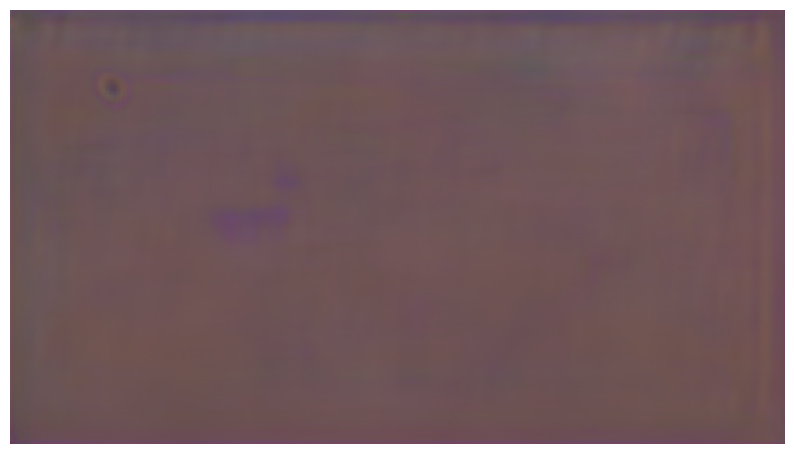

In [27]:
with torch.no_grad():
  print(Params().shape)
  img= norm_data(generador(Params()).cpu())
  print(img.shape)
  show_from_ten(img[0])

# create Crops

In [28]:
def create_crops(img, num_crops=32):
  padd= size1//2
  img= torch.nn.functional.pad(img, (padd,padd,padd,padd), mode='constant', value=0) #1x 3x 448x 624
  img=  augmentTransform(img)

  crop_set= []
  for ch in range(num_crops):
    gap1= int(torch.normal(1.6, .2, ()).clip(.6 , 1.1)*size1)
    gap2= int(torch.normal(1, .5, ()).clip(.2 , 1.5)*size1)
    offsetx= torch.randint(0, int(size1*2-gap1),())
    offsety= torch.randint(0, int(size1*2-gap1),())

    crop= img[:,:,offsetx:offsetx+gap1, offsety:offsety+gap1 ]
    crop= torch.nn.functional.interpolate(crop,(224,224), mode='bilinear',align_corners=True)
    crop_set.append(crop)

  img_crops= torch.cat(crop_set, 0)
  rand_normal= torch.randn_like(img_crops, requires_grad=False)
  randnums= 6
  randtotal= torch.rand((img_crops.shape[0],1,1,1)).cuda() #32

  for ns in range(randnums):
    randtotal*=torch.rand((img_crops.shape[0],1,1,1)).cuda() #Sfumato effect

  img_crops= img_crops+ noise_factor*rand_normal*randtotal
  return img_crops



In [97]:
def showme1(Params, show_crop):
  with torch.no_grad():
    generated= generador(Params())

    if (show_crop):
      print('Augmented cropped example')
      aug_gen= generated.float()

      aug_gen= create_crops(aug_gen, num_crops=1)
      aug_gen_norm= norm_data(aug_gen[0])
      show_from_ten(aug_gen_norm)

    print('Generation')
    latest_gen= norm_data(generated.cpu())
    show_from_ten(latest_gen[0])

    return (latest_gen[0])



# Optimizing Latent space

In [98]:
def optimize_result(Params, prompt):
  alpha=1 # importance for including
  beta=.5 # importance for excluding

  out= generador(Params())
  out= norm_data(out)
  out= create_crops(out)
  out= normalize(out) #30 x 3 x 224 x 224
  image_encode= clipmodel.encode_image(out) #30 x 512

  #text encoding
  final_enc= w1*prompt + w2*extras_enc
  final_text_include= final_enc / final_enc.norm(dim=-1, keepdim=True)
  final_text_exclude= exclude_enc

  #Calculate loss
  main_loss= torch.cosine_similarity(final_text_include, image_encode, -1) #30
  penalize_loss= torch.cosine_similarity(final_text_exclude, image_encode, -1)

  final_loss= -alpha*main_loss + beta*penalize_loss
  return final_loss

def optimize(Params, optimizer, prompt):
  loss= optimize_result(Params, prompt).mean()
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss

# Training loop

In [99]:
def training_loop(Params, optimizer, show_crop=False):
  res_img=[]
  res_z= []

  for prompt in include_enc:
    iteration=0
    Params, optimizer = init_params()

    for it in range(total_iter):
      loss= optimize(Params, optimizer, prompt)

      if iteration>79 and iteration%(total_iter-1)==0:
        new_img= showme1(Params, show_crop)
        res_img.append(new_img)
        res_z.append(Params())
        print('Loss: ', loss.item(), 'Iteration: ', iteration)

      iteration= iteration+1
    torch.cuda.empty_cache()

    return res_img, res_z

In [100]:
torch.cuda.empty_cache()

In [115]:
include= ['dog jumping in a car']
exclude= 'watermark'
extras= ''
w1=1
w2=1
noise_factor= .35

In [116]:
include_enc, exclude_enc, extras_enc= create_encodings(include, exclude, extras)

Augmented cropped example


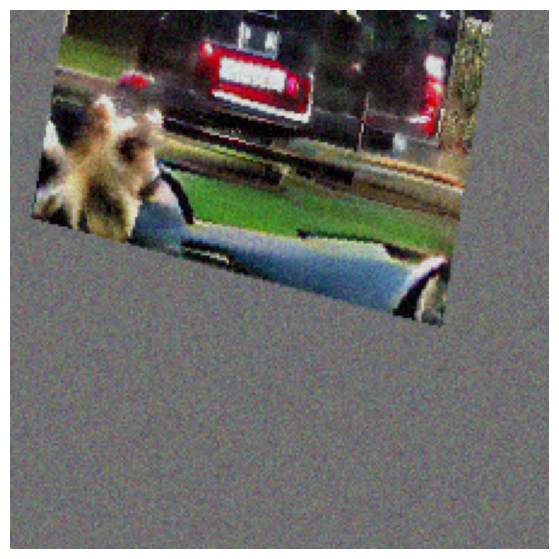

Generation


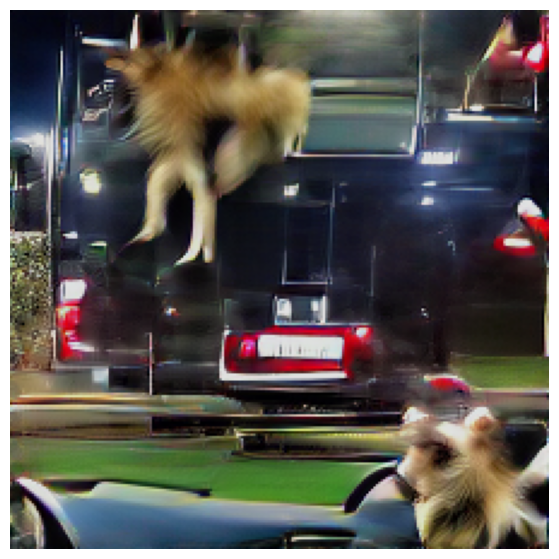

Loss:  -0.1832275390625 Iteration:  99


In [117]:
res_img, res_z = training_loop(Params, optimizer, show_crop= True)

In [ ]:
def interpolate(res_z_list, duration_list):
  gen_img=[]
  fps=25

  for idx, (z_duration) in enumerate(zip(res_z_list, duration_list)):
    num_steps = int(duration*fps)
    z1= z
    z2= res_z_list[(idx+1)%len(res_z_list)]
    for step in range(num_steps):
      alpha= math.sin(1.5*step/num_steps)**6
      z_new= alpha * z2+(1-alpha)*z1
      new_gen=norm_data(generator(z_new).cpu())[0]
      new_gen=T.ToPILImage(mode='RGB')(new_gen)
      gen_img_list.append(new_img)

    return gen_img_list

durations=[3,3,3,3,3,3]
interp_values= interpolate(res_z, durations)


In [ ]:
#create video
out_video_path='../res1.mp4'
writer= imageio.get_writer(out_video_path, fps=25)
for pil_img in interp_result_img_list:
  img= np.array(pil_img, dtype= np.unit8)
  writer.append_data(img)
  writer.close()

In [ ]:
from IPython.display import HTML
from base64 import b64encode

mp4= open('../res1.mp4','rb').read()
data="data:video/mp4;base64,"+b64encode(mp4).decode()
HTML("""<video width=800 controls><source src="%s" type="video/mp4"></video>""" % data)